In [2]:
# Imports for Analysis
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import hvplot.pandas

# Imports for API 
import requests
import json
from config import geoapify_key

In [19]:
# Import the csv file
file_path = './Resources/global_electricity_production_data.csv'
raw_df = pd.read_csv(file_path)

# Display the file
raw_df.head(20)

,country_name,date,parameter,product,value,unit
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.19,GWh
1,Australia,12/1/2023,Net Electricity Production,Total Combustible Fuels,13397.94,GWh
2,Australia,12/1/2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",9768.52,GWh
3,Australia,12/1/2023,Net Electricity Production,Oil and Petroleum Products,289.54,GWh
4,Australia,12/1/2023,Net Electricity Production,Natural Gas,3091.93,GWh
5,Australia,12/1/2023,Net Electricity Production,Combustible Renewables,247.94,GWh
6,Australia,12/1/2023,Net Electricity Production,Hydro,1047.85,GWh
7,Australia,12/1/2023,Net Electricity Production,Wind,2719.25,GWh
8,Australia,12/1/2023,Net Electricity Production,Solar,5481.15,GWh
9,Australia,12/1/2023,Net Electricity Production,"Total Renewables (Hydro, Geo, Solar, Wind, Other)",9496.20,GWh


# Electricity Production World Comparsion

In [3]:
# Filter the raw dataframe down to only total production of electricity
production_filter = (raw_df['parameter'] == 'Net Electricity Production')&(raw_df['product']=='Electricity')
production_df = raw_df[production_filter]

# Display dataframe
production_df.head()

,country_name,date,parameter,product,value,unit
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.1901,GWh
13,Austria,12/1/2023,Net Electricity Production,Electricity,6783.2730,GWh
31,Belgium,12/1/2023,Net Electricity Production,Electricity,6799.1069,GWh
49,Canada,12/1/2023,Net Electricity Production,Electricity,55982.2209,GWh
68,Chile,12/1/2023,Net Electricity Production,Electricity,7734.9912,GWh


In [4]:
# Group the dataframe by country and sum the value
production_by_country = production_df.groupby('country_name')['value'].sum()
production_by_country_df = production_by_country.reset_index()

# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display dataframe
production_by_country_df.head()

,country_name,value
0,Argentina,1236051.53
1,Australia,3445110.16
2,Austria,929163.77
3,Belgium,1156238.38
4,Brazil,5530395.77


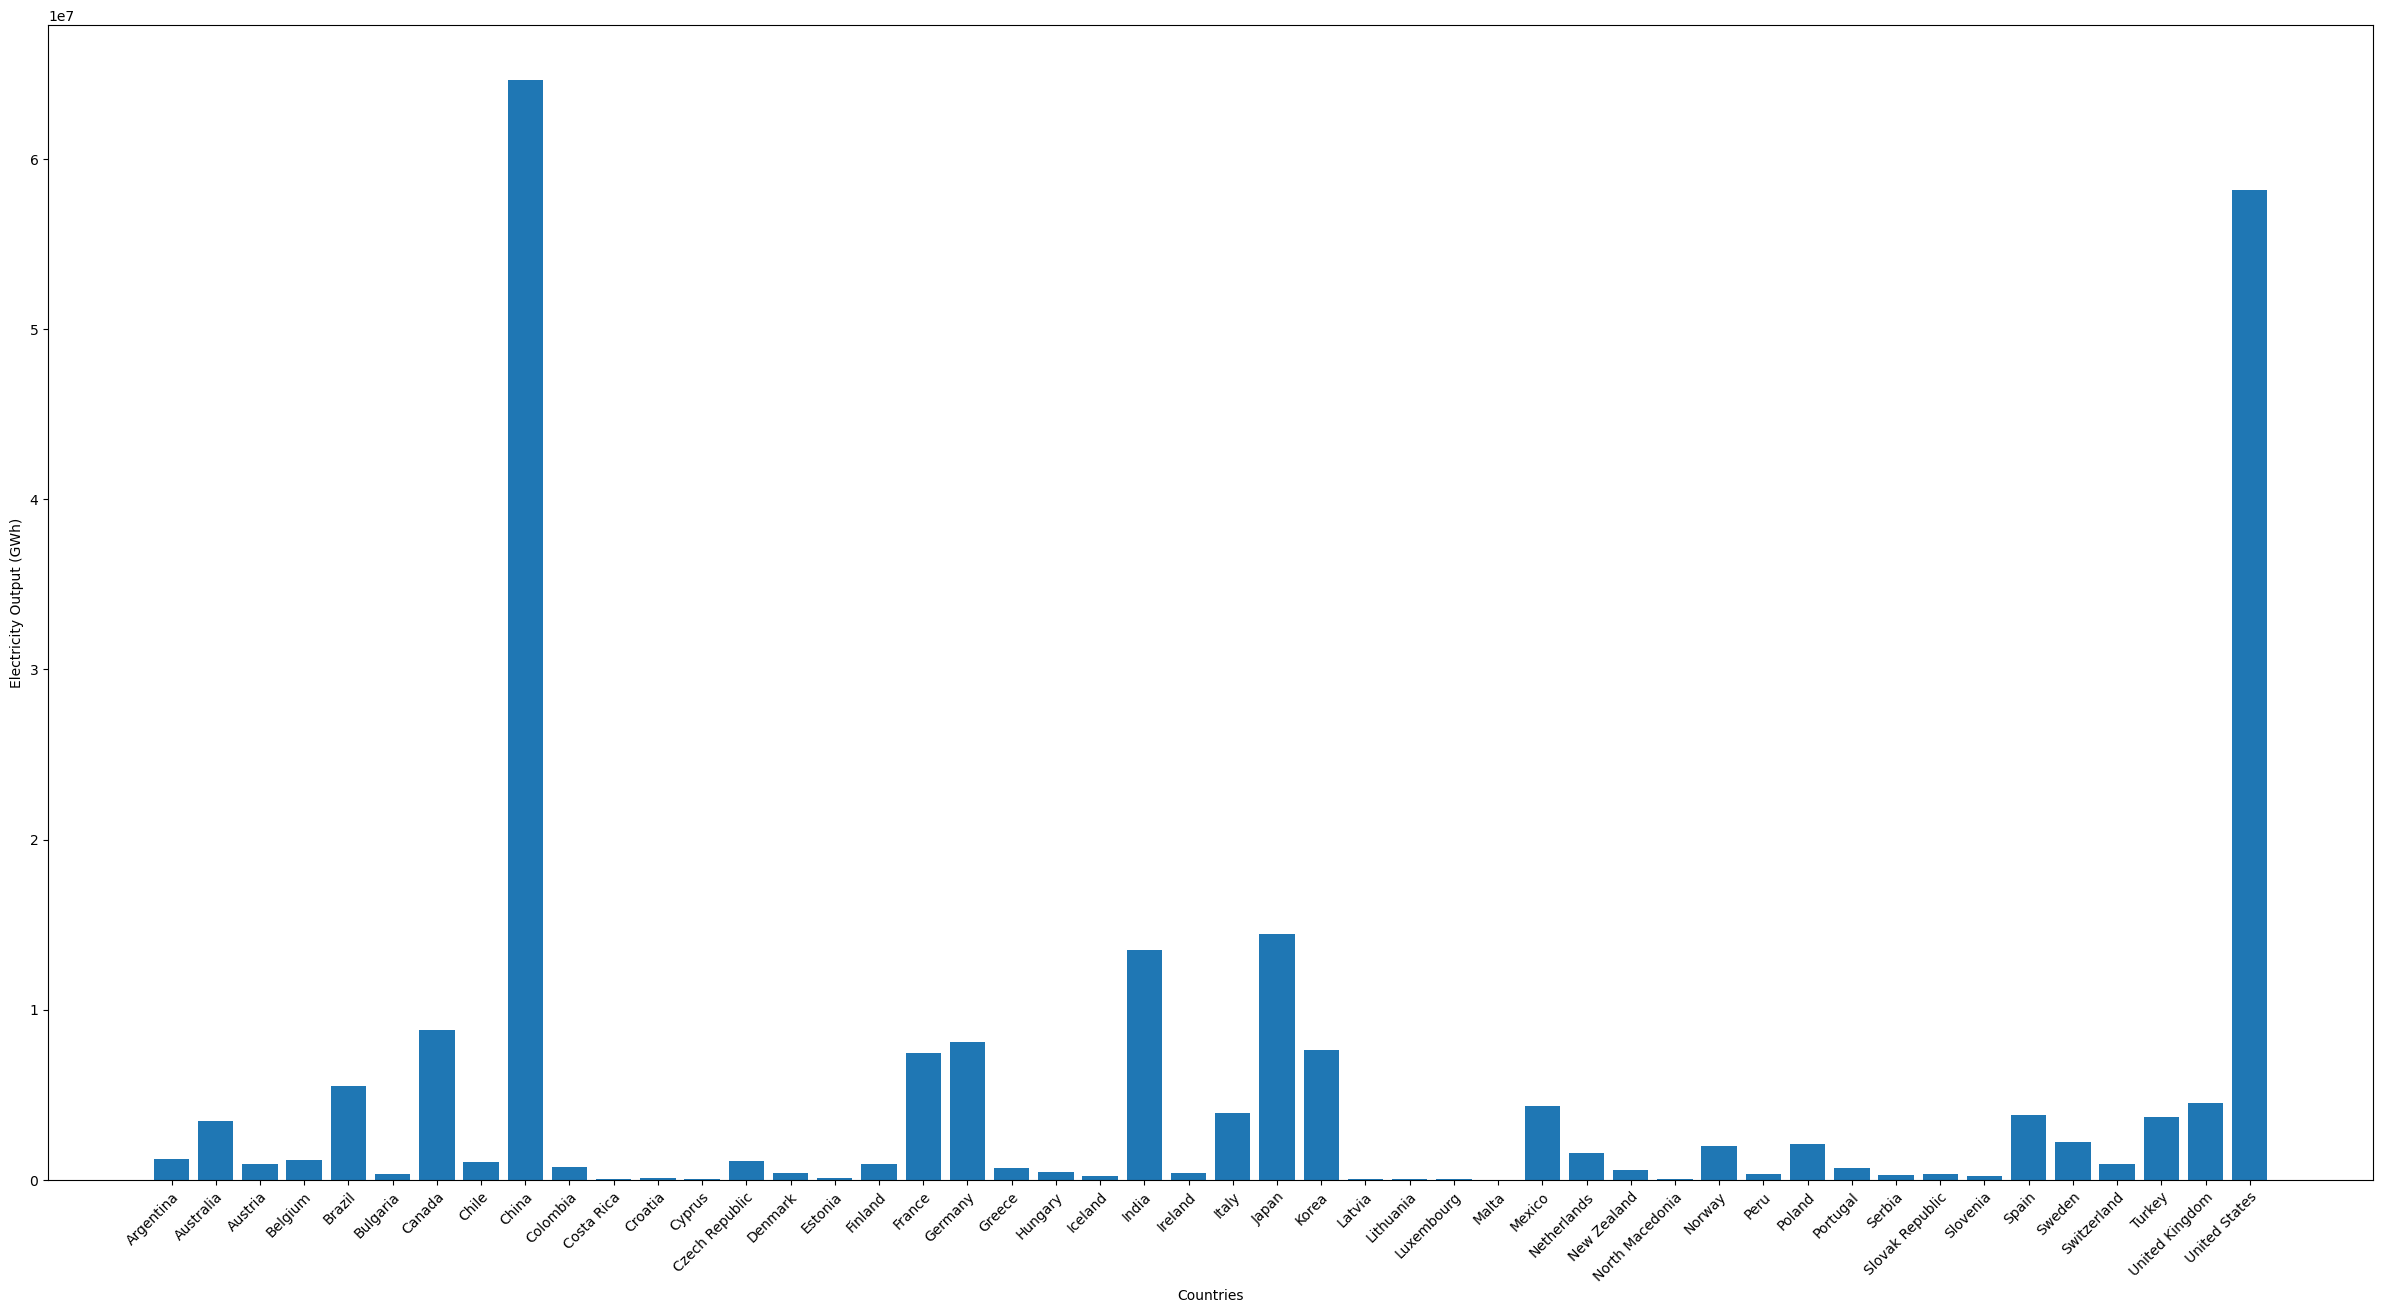

In [5]:
# Create a bar plot of all countries elerticity production
fig, ax = plt.subplots(figsize=(30,15))
ax.bar(production_by_country_df['country_name'], production_by_country_df['value'])

# Create labels
ax.set_xticks(ticks=production_by_country_df['country_name'],labels=production_by_country_df['country_name'],rotation_mode='anchor',ha='right', rotation=45)
ax.set_xlabel('Countries')
ax.set_ylabel('Electricity Output (GWh)')

# Display the plot
plt.show()

In [6]:
# Create lists for the latitudes and longitudes of each country
list_of_lats = []
list_of_lons = []

# Loop through Geoapify and extract the latitudes and longitudes of each country
for country in production_by_country_df['country_name']:
    # Collect JSON request for a country in the dataframe
    query_url = f"https://api.geoapify.com/v1/geocode/search?text={country}&format=json&apiKey={geoapify_key}"
    json_response = requests.get(query_url).json()

    # Extract the lat and lons
    lat_response = json_response['results'][0]['lat']
    lon_response = json_response['results'][0]['lon']

    # Add them to each list
    list_of_lats.append(lat_response)
    list_of_lons.append(lon_response)

# Add the lats and lons to the dataframe
production_by_country_df['lat'] = list_of_lats
production_by_country_df['lon'] = list_of_lons

# Display dataframe
production_by_country_df.head()


,country_name,value,lat,lon
0,Argentina,1236051.53,-35.00,-64.97
1,Australia,3445110.16,-24.78,134.75
2,Austria,929163.77,47.59,14.12
3,Belgium,1156238.38,50.64,4.67
4,Brazil,5530395.77,-10.33,-53.20


In [7]:
# Configure the map plot of each country with size based on electricity production
map_plot_1 = production_by_country_df.hvplot.points('lon', 
                                          'lat', 
                                          geo=True,
                                          tiles='OSM',
                                          frame_width = 700,
                                          frame_height = 500,
                                          color ='country_name',
                                          size='value',
                                          alpha=.5,
                                          scale = .01)

# Display the map plot
map_plot_1 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (country_name,value)

# Electricity Produced by Fossil Fuels Compared to Renewables

In [8]:
# Filter raw dataframe for combustibles, renewables, and combustible renewables
total_combustible_df = raw_df[(raw_df['parameter']=='Net Electricity Production')&(raw_df['product']=='Total Combustible Fuels')]
combustible_renewables_df = raw_df[(raw_df['parameter']=='Net Electricity Production')&(raw_df['product']=='Combustible Renewables')]
total_renewables_df = raw_df[(raw_df['parameter']=='Net Electricity Production')&(raw_df['product']=='Total Renewables (Hydro, Geo, Solar, Wind, Other)')]

# Rename columns 
total_combustible_df = total_combustible_df.rename(columns={'value':'Combustible Fuel'})
combustible_renewables_df = combustible_renewables_df.rename(columns={'value':'Combustible Renewables'})
total_renewables_df = total_renewables_df.rename(columns={'value':'Total Renewables'})

# Drop unneeded columns
total_combustible_df = total_combustible_df.drop(columns={'parameter','unit','product'})
combustible_renewables_df = combustible_renewables_df.drop(columns={'parameter','unit','product'})
total_renewables_df = total_renewables_df.drop(columns={'parameter','unit','product'})

# Merge Dataframes
all_combutibles_df = pd.merge(total_combustible_df, combustible_renewables_df)
main_df = pd.merge(all_combutibles_df, total_renewables_df)

# Create column with only non-renewable combustible fuel
main_df['Fossil Fuels'] = main_df['Combustible Fuel']-main_df['Combustible Renewables']

# Create a column for the year
main_df['Year'] = main_df['date'].str.split('/').str[-1]

# Display merged data frame
main_df.head()

,country_name,date,Combustible Fuel,Combustible Renewables,Total Renewables,Fossil Fuels,Year
0,Australia,12/1/2023,13397.94,247.94,9496.20,13149.99,2023
1,Austria,12/1/2023,1746.90,407.40,5443.14,1339.50,2023
2,Belgium,12/1/2023,1521.76,200.90,2556.33,1320.86,2023
3,Canada,12/1/2023,11574.95,928.45,37760.48,10646.50,2023
4,Chile,12/1/2023,2099.87,386.20,6021.32,1713.67,2023


In [9]:
# Create groupby for fossil and renewable based on country and year
fossil_renew_grouped_by_country_year = main_df.groupby(['country_name','Year'])[['Fossil Fuels','Total Renewables']].sum()

# renewables_grouped_by_country_year = main_df.groupby(['country_name','Year'])['Total Renewables'].sum()
fossil_renew_grouped_by_country_year

Fossil Fuels  Total Renewables
country_name  Year                                
Argentina     2015      97379.18          33567.57
              2016     100338.11          31013.89
              2017      98852.40          33292.21
              2018      98021.59          34652.22
              2019      89968.76          34524.08
...                          ...               ...
United States 2019    2606126.95         775304.57
              2020    2450705.23         806946.32
              2021    2532061.10         873123.23
              2022    2581065.98         975828.84
              2023    2519199.59         958799.74

[589 rows x 2 columns]

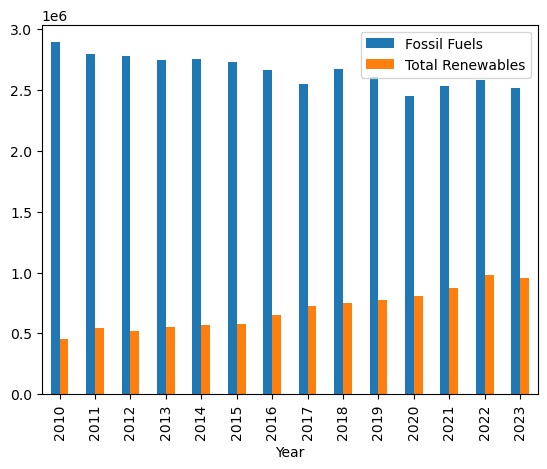

In [10]:
# United States Fossil to renwable ratio over the years
fossil_renew_grouped_by_country_year.loc['United States'].plot(kind='bar')

# Display Plot
plt.show()

In [11]:
# Create a column for fossil to renewable ratio
fossil_renew_grouped_by_country_year['Fossil to Renewable Ratio'] = fossil_renew_grouped_by_country_year['Fossil Fuels']/fossil_renew_grouped_by_country_year['Total Renewables']
fossil_renew_grouped_by_country_year = fossil_renew_grouped_by_country_year.reset_index()

# Display dataframe
fossil_renew_grouped_by_country_year

,country_name,Year,Fossil Fuels,Total Renewables,Fossil to Renewable Ratio
0,Argentina,2015,97379.18,33567.57,2.90
1,Argentina,2016,100338.11,31013.89,3.24
2,Argentina,2017,98852.40,33292.21,2.97
3,Argentina,2018,98021.59,34652.22,2.83
4,Argentina,2019,89968.76,34524.08,2.61
...,...,...,...,...,...
584,United States,2019,2606126.95,775304.57,3.36
585,United States,2020,2450705.23,806946.32,3.04
586,United States,2021,2532061.10,873123.23,2.90
587,United States,2022,2581065.98,975828.84,2.64


In [12]:
# Filter for only the most recent year
fossil_renew_grouped_by_country_2023 = fossil_renew_grouped_by_country_year[fossil_renew_grouped_by_country_year['Year']=='2023']

# Display dataframe
fossil_renew_grouped_by_country_2023.head()

,country_name,Year,Fossil Fuels,Total Renewables,Fossil to Renewable Ratio
8,Argentina,2023,80135.75,41461.54,1.93
22,Australia,2023,162879.67,98690.91,1.65
36,Austria,2023,10498.63,57444.95,0.18
50,Belgium,2023,19934.84,27160.11,0.73
59,Brazil,2023,55046.20,621612.97,0.09


# Top 10 Countries with the Highest (Worst) Fossil to Renewable Ratio

In [13]:
# Display the the top 10 countries with the highest fossil fuel to renewable fuel ratio
sorted_by_ratio_worst = fossil_renew_grouped_by_country_2023.sort_values(by='Fossil to Renewable Ratio', ascending=False)
sorted_by_ratio_worst.head(10)

,country_name,Year,Fossil Fuels,Total Renewables,Fossil to Renewable Ratio
368,Malta,2023,498.43,48.13,10.36
317,Korea,2023,358455.82,54523.70,6.57
382,Mexico,2023,327115.05,61670.30,5.30
136,Cyprus,2023,4042.90,1081.64,3.74
261,India,2023,1364489.42,392418.56,3.48
150,Czech Republic,2023,30646.37,11042.95,2.78
303,Japan,2023,645039.90,236716.38,2.72
588,United States,2023,2519199.59,958799.74,2.63
453,Poland,2023,108426.03,45150.99,2.40
105,China,2023,5789533.49,2896375.84,2.00


# Top 10 Countries with the Lowest (Best) Fossil to Renewable Ratio

In [14]:
# Display the the top 10 countries with the lowest fossil fuel to renewable fuel ratio
sorted_by_ratio_best = fossil_renew_grouped_by_country_2023.sort_values(by='Fossil to Renewable Ratio', ascending=True)
sorted_by_ratio_best.head(10)

,country_name,Year,Fossil Fuels,Total Renewables,Fossil to Renewable Ratio
118,Costa Rica,2023,18.86,11399.36,0.00
433,Norway,2023,1660.57,151867.07,0.01
532,Sweden,2023,2439.70,112175.12,0.02
546,Switzerland,2023,1423.32,49301.56,0.03
359,Luxembourg,2023,132.98,2147.14,0.06
59,Brazil,2023,55046.20,621612.97,0.09
164,Denmark,2023,2934.44,30824.23,0.10
192,Finland,2023,4224.19,41988.60,0.10
410,New Zealand,2023,5043.77,37950.09,0.13
36,Austria,2023,10498.63,57444.95,0.18


In [15]:
# Drop columns and set index to country name for plotting
fossil_renew_grouped_by_country_2023 = fossil_renew_grouped_by_country_2023.drop(columns=['Year','Fossil to Renewable Ratio'])
fossil_renew_grouped_by_country_2023 = fossil_renew_grouped_by_country_2023.set_index('country_name')
fossil_renew_grouped_by_country_2023.head()

,Fossil Fuels,Total Renewables
country_name,,
Argentina,80135.75,41461.54
Australia,162879.67,98690.91
Austria,10498.63,57444.95
Belgium,19934.84,27160.11
Brazil,55046.20,621612.97


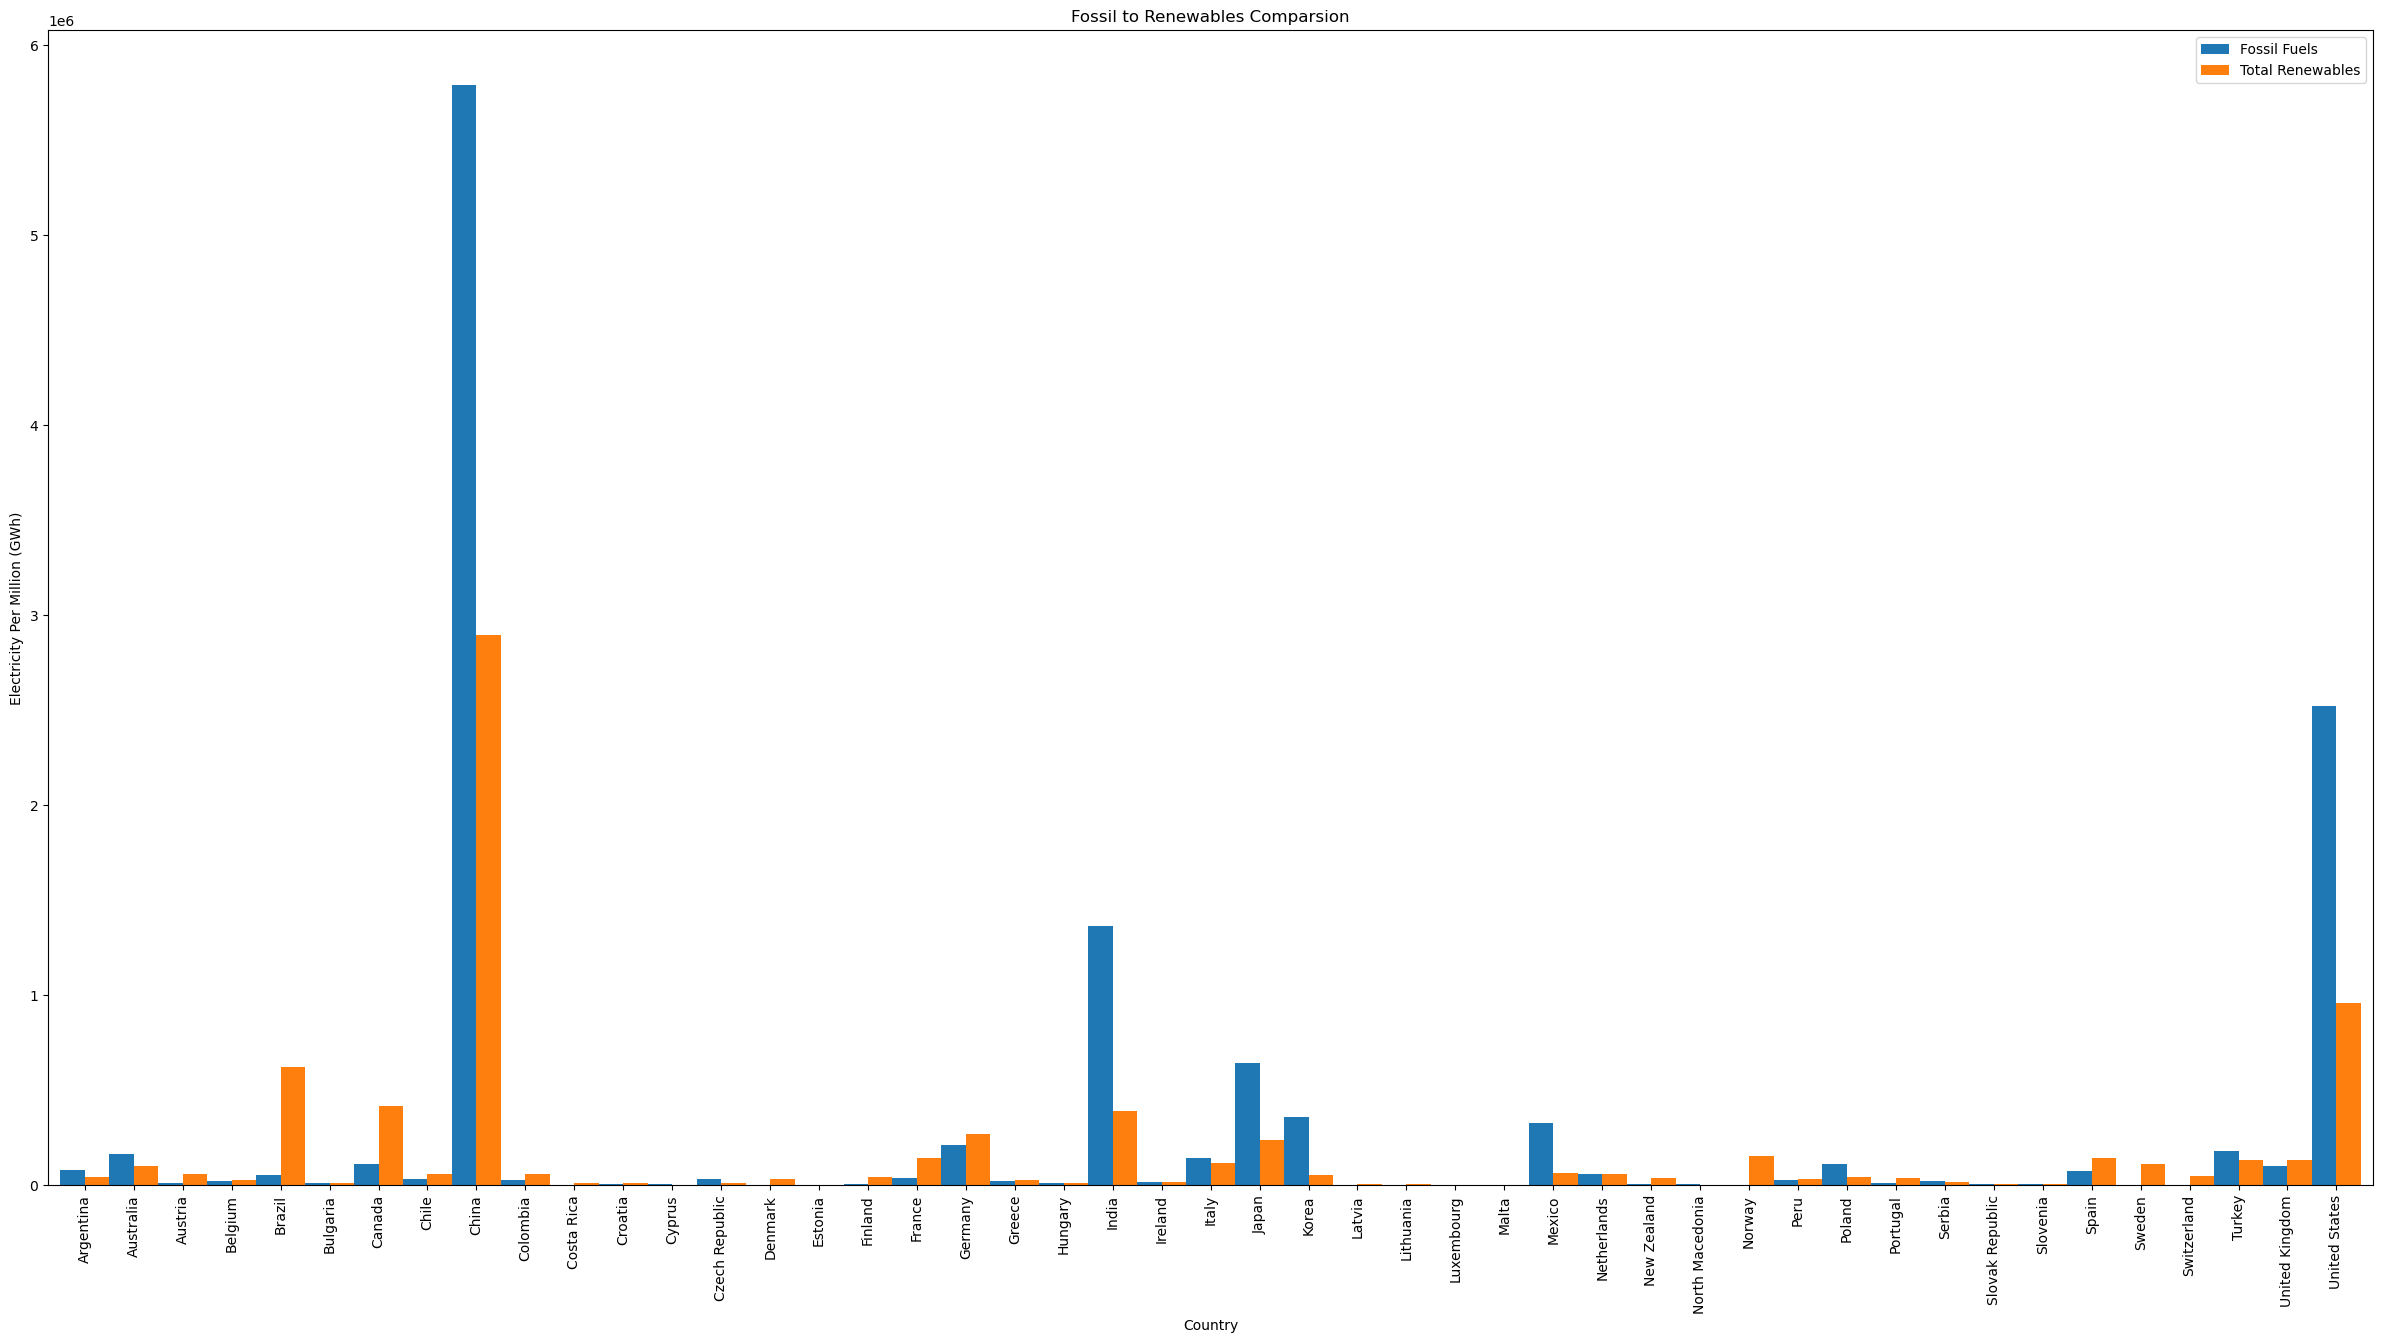

In [16]:
# Create a bar plot of all countries elerticity production
fossil_renew_grouped_by_country_2023.plot(kind='bar', 
                                          figsize=(30,15), 
                                          width=1,
                                          xlabel='Country',
                                          ylabel='Electricity Per Million (GWh)',
                                          title='Fossil to Renewables Comparsion')

# Display plot
plt.show()
